# Segmentacja klientów

## Przygotowanie danych
Celem tego kroku jest przygotowanie danych tak, by podczas agregacji dla każdego z klientów zachować jak najwięcej informacji. Te dane pomogą w przeprowadzeniu segmentacji.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [33]:
df = pd.read_csv('data/Dataset_Transaction.csv', sep=';', decimal=',')
df.TransactionDate = pd.to_datetime(df.TransactionDate) # we can omit exact time as it is always 00:00
df[["AlcoholName", "AlcoholClass", "AlcoholId"]] = df.ProductName.str.split(expand=True)
df.head()

,CustomerId,CustomerType,CustomerChannel,CustomerStatus,CustomerLongitude,CustomerLatitude,ProductName,TransactionDate,TransactionValue,AlcoholName,AlcoholClass,AlcoholId
0,1040,Spoza sieci,Restaurant,Obsługiwany przez PH,21.871591,50.529442,Rum Premium 88,2017-01-05,431.91,Rum,Premium,88
1,1040,Spoza sieci,Restaurant,Obsługiwany przez PH,21.871591,50.529442,Whisky Classic 372,2017-01-05,1549.85,Whisky,Classic,372
2,1723,Sieć,Shop,Nieobsługiwany,15.758878,54.216344,Whisky Classic 50,2017-01-05,555.15,Whisky,Classic,50
3,1040,Spoza sieci,Restaurant,Obsługiwany przez PH,21.871591,50.529442,Likier Standard 156,2017-01-05,1206.00,Likier,Standard,156
4,1040,Spoza sieci,Restaurant,Obsługiwany przez PH,21.871591,50.529442,Likier Standard 160,2017-01-05,1674.00,Likier,Standard,160


### One-hot encoding dla rodzajów alkoholu

In [43]:
one_hot = pd.get_dummies(df.AlcoholName)
alco_data = pd.concat([df.CustomerId, one_hot], axis=1)
alco_data.head()

,CustomerId,Brandy,Gin,Koniak,Likier,Others,Rum,Szampan,Tequila,Whisky,Wino,Wódka
0,1040,0,0,0,0,0,1,0,0,0,0,0
1,1040,0,0,0,0,0,0,0,0,1,0,0
2,1723,0,0,0,0,0,0,0,0,1,0,0
3,1040,0,0,0,1,0,0,0,0,0,0,0
4,1040,0,0,0,1,0,0,0,0,0,0,0


### Ograniczenie kolumn

In [30]:
data = df.drop(['CustomerStatus', 'CustomerLongitude', 'CustomerLatitude', 'ProductName', 'TransactionDate', 'AlcoholClass', 'AlcoholId'], axis=1)
data.head()

,CustomerId,CustomerType,CustomerChannel,TransactionValue,Brandy,Gin,Koniak,Likier,Others,Rum,Szampan,Tequila,Whisky,Wino,Wódka
0,1040,Spoza sieci,Restaurant,431.91,0,0,0,0,0,1,0,0,0,0,0
1,1040,Spoza sieci,Restaurant,1549.85,0,0,0,0,0,0,0,0,1,0,0
2,1723,Sieć,Shop,555.15,0,0,0,0,0,0,0,0,1,0,0
3,1040,Spoza sieci,Restaurant,1206.00,0,0,0,1,0,0,0,0,0,0,0
4,1040,Spoza sieci,Restaurant,1674.00,0,0,0,1,0,0,0,0,0,0,0


### Agregacja

In [ ]:
data_agg = data.groupby('CustomerId').agg({'CustomerType': 'first', 'CustomerChannel': 'first', 'TransactionValue': ['count','sum']})
alco_agg = alco_data.groupby('CustomerId').sum()

In [53]:
aggregated = data_agg.merge(alco_agg, on='CustomerId')
aggregated.columns = ["CustomerType", "CustomerChannel", "TransactionCount", "TransactionSum"] + aggregated.columns[4:].tolist()
aggregated.head()

C:\Users\zgawrysi\AppData\Local\Temp\ipykernel_26384\3440832479.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  aggregated = data_agg.merge(alco_agg, on='CustomerId')


,CustomerType,CustomerChannel,TransactionCount,TransactionSum,Brandy,Gin,Koniak,Likier,Others,Rum,Szampan,Tequila,Whisky,Wino,Wódka
CustomerId,,,,,,,,,,,,,,,
1,Sieć,Shop,3,1242.52,0,0,0,0,0,0,0,0,2,0,1
4,Sieć,Shop,3,1112.93,0,0,0,0,0,0,0,0,1,0,2
6,Spoza sieci,Shop,3,582.63,0,0,0,0,0,0,0,0,1,0,2
7,Sieć,Shop,14,6339.20,0,0,0,0,0,0,0,0,3,0,11
9,Sieć,Shop,4,704.84,0,0,0,0,0,0,0,0,0,0,4


## Segmentacja

### Proste klastrowanie
Na początek wykorzystam tylko dwie kolumny - liczbę oraz sumę transakcji. Przed klastrowaniem dane muszą zostać znormalizowane oraz ustandaryzowane.

In [82]:
simple = aggregated[['TransactionCount', 'TransactionSum']]
simple = np.log(simple)
std_scaler = StandardScaler()
simple_scaled = std_scaler.fit_transform(simple)

By wybrać odpowiednią liczbę klastrów, skorzystam z [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

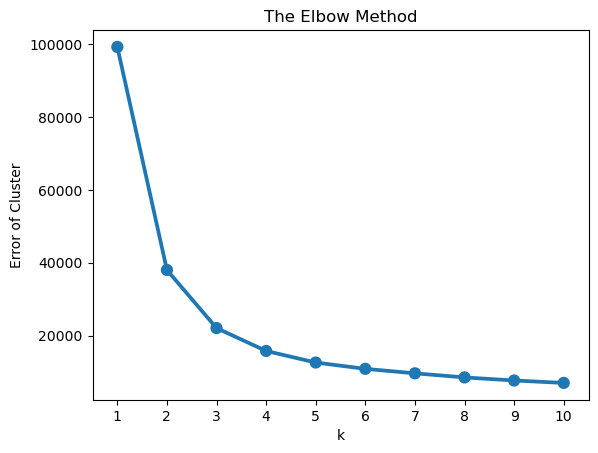

In [84]:
errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=23)
    model.fit(simple_scaled)
    errors.append(model.inertia_)
    
 
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('Error of Cluster')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.show()

In [85]:
model = KMeans(n_clusters=3, random_state=23)
model.fit(simple_scaled)

KMeans(n_clusters=3, random_state=23)

In [96]:
simple = simple.assign(ClusterLabel=model.labels_)

In [88]:
simple.groupby("ClusterLabel")[['TransactionCount', 'TransactionSum']].median()


,TransactionCount,TransactionSum
ClusterLabel,,
0,3.465736,9.428992
1,0.693147,6.225884
2,2.197225,7.911359


In [101]:
simple = simple.astype({"ClusterLabel" : "category"})

fig = px.scatter(
    data_frame=simple,
    x="TransactionCount",
    y="TransactionSum",
    title="Relationship between number of transactions and transaction values",
    color="ClusterLabel",
)
fig.show()

Klienci zostali podzieleni według wydatków.

### Projekcja danych
By w grupowaniu wziąć pod uwagę więcej parametrów - skorzytam z metody [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).